#final implementation

In [ ]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Model Selection & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# 2. Load the NSL-KDD Dataset
print("Downloading and Loading NSL-KDD Dataset...")
train_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt'
test_url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt'

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

df_train = pd.read_csv(train_url, header=None, names=col_names)
df_test = pd.read_csv(test_url, header=None, names=col_names)

# Remove 'difficulty' column (not needed for binary classification)
df_train.drop(['difficulty'], axis=1, inplace=True)
df_test.drop(['difficulty'], axis=1, inplace=True)

# 3. Label Encoding (Binary Classification: Normal=0, Attack=1)
def encode_label(df):
    df.label.replace(['normal'], 0, inplace=True)
    df.label.replace([i for i in df.label.unique() if i!=0], 1, inplace=True)

encode_label(df_train)
encode_label(df_test)

# 4. Handle Categorical Features
# Using LabelEncoder for 'protocol_type', 'service', 'flag'
categorical_cols = ['protocol_type', 'service', 'flag']
combined = pd.concat([df_train, df_test]) # Fit on combined data to cover all categories

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(combined[col])
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

# 5. Feature Scaling
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']
X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Data Loaded. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

/tmp/ipython-input-3334930481.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['normal'], 0, inplace=True)
/tmp/ipython-input-3334930481.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.label.replace([i for i in df.label.unique() if i!=0], 1, inplace=True)


Data Loaded. Train Shape: (125973, 41), Test Shape: (22544, 41)


In [ ]:
# Dictionary to store model results
results = {}

# Define the 6 Standalone Models
models = {
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Backpropagation NN": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
}

print("Models Initialized.")

Models Initialized.


In [ ]:
print("Training Standalone Models...")
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predict
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f} (Time: {train_time:.2f}s)")

    # Optional: Show confusion matrix for each (comment out to save space)
    # print(confusion_matrix(y_test, y_pred))

Training Standalone Models...
Decision Tree Accuracy: 0.8009 (Time: 0.94s)
Naive Bayes Accuracy: 0.7714 (Time: 0.10s)
Random Forest Accuracy: 0.7707 (Time: 14.20s)
AdaBoost Accuracy: 0.7904 (Time: 11.71s)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:30:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8009 (Time: 1.96s)
Backpropagation NN Accuracy: 0.7785 (Time: 106.28s)


In [ ]:
print("\nTraining Ensembled RF-BPNN (Hybrid Model)...")

# Step 1: Train Random Forest (already done in loop, but explicit here for clarity)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 2: Get Probability outputs from RF to use as features
rf_train_prob = rf.predict_proba(X_train)[:, 1].reshape(-1, 1) # Probability of being 'Attack'
rf_test_prob = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)

# Step 3: Stack features (Original Data + RF Probabilities)
# This gives the Neural Network a "hint" from the Random Forest
X_train_hybrid = np.hstack((X_train, rf_train_prob))
X_test_hybrid = np.hstack((X_test, rf_test_prob))

# Step 4: Train Backpropagation NN on the Hybrid Data
bpnn_hybrid = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300, random_state=42)
start_time = time.time()
bpnn_hybrid.fit(X_train_hybrid, y_train)
train_time = time.time() - start_time

# Step 5: Evaluate Hybrid Model
y_pred_hybrid = bpnn_hybrid.predict(X_test_hybrid)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)

results["Ensembled RF-BPNN"] = acc_hybrid
print(f"Ensembled RF-BPNN Accuracy: {acc_hybrid:.4f} (Time: {train_time:.2f}s)")


Training Ensembled RF-BPNN (Hybrid Model)...
Ensembled RF-BPNN Accuracy: 0.7886 (Time: 14.73s)


/tmp/ipython-input-2428434575.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette='viridis')


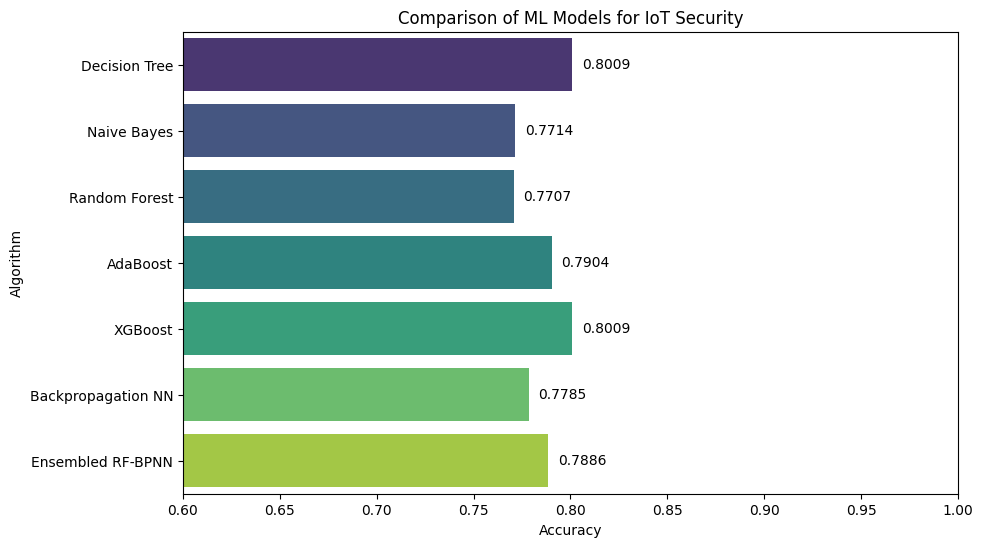

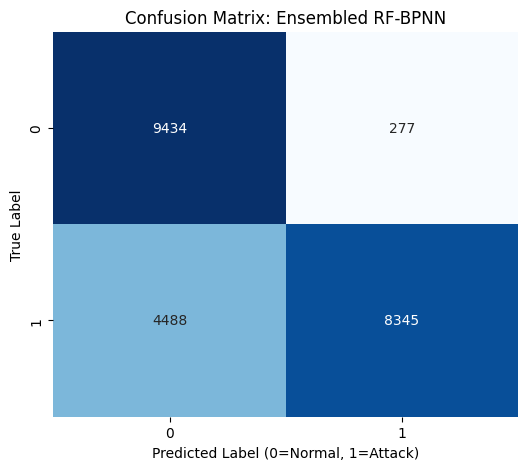

In [ ]:
# --- Visualization 1: Accuracy Comparison Bar Chart ---
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())

# Create Bar Plot
sns.barplot(x=accuracies, y=model_names, palette='viridis')
plt.xlim(0.6, 1.0)  # Zoom in to see differences clearly
plt.title('Comparison of ML Models for IoT Security')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')

# Add text labels on bars
for i, v in enumerate(accuracies):
    plt.text(v + 0.005, i, f"{v:.4f}", va='center')

plt.show()

# --- Visualization 2: Confusion Matrix (Best Model) ---
# We display the matrix for the Hybrid Model
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Ensembled RF-BPNN')
plt.xlabel('Predicted Label (0=Normal, 1=Attack)')
plt.ylabel('True Label')
plt.show()

In [ ]:
import time
import random

# --- STEP 6: REAL-TIME ATTACK SIMULATION ---

print("----------------------------------------------------------------")
print("   IoT SECURITY SYSTEM: AI-BASED REACTION AGENT ONLINE")
print("----------------------------------------------------------------")
print("Monitoring Network Traffic... (Press Stop to End)")
print("----------------------------------------------------------------")

# Mapping for readable output
attack_map = {0: "NORMAL TRAFFIC", 1: "⚠️ ATTACK DETECTED!"}

# Pick 20 random samples from the test set to simulate "live" incoming packets
# We use the hybrid data (X_test_hybrid) because that's what our best model needs
random_indices = np.random.choice(len(X_test_hybrid), size=20, replace=False)

for i in random_indices:
    # 1. Get the data packet (simulated)
    packet_data = X_test_hybrid[i].reshape(1, -1)

    # 2. Ask the Ensembled RF-BPNN model to predict
    prediction = bpnn_hybrid.predict(packet_data)[0]

    # 3. Get Confidence Score (Probability)
    confidence = bpnn_hybrid.predict_proba(packet_data).max() * 100

    # 4. Display Logic
    status = attack_map[prediction]

    # Simulation delay to make it look like real-time monitoring
    time.sleep(1.0)

    if prediction == 1:
        # Print Attack in Red (using ANSI codes for Colab)
        print(f"\033[91m[ALERT] Packet ID: {i} | Type: {status} | Confidence: {confidence:.2f}%\033[0m")
        print(f"        Action: BLOCKED BY SDN CONTROLLER")
    else:
        # Print Normal in Green
        print(f"\033[92m[INFO]  Packet ID: {i} | Type: {status} | Confidence: {confidence:.2f}%\033[0m")
        print(f"        Action: ALLOWED")

print("----------------------------------------------------------------")
print("Simulation Complete.")

----------------------------------------------------------------
   IoT SECURITY SYSTEM: AI-BASED REACTION AGENT ONLINE
----------------------------------------------------------------
Monitoring Network Traffic... (Press Stop to End)
----------------------------------------------------------------
[ALERT] Packet ID: 5306 | Type: ⚠️ ATTACK DETECTED! | Confidence: 100.00%
        Action: BLOCKED BY SDN CONTROLLER
[INFO]  Packet ID: 16392 | Type: NORMAL TRAFFIC | Confidence: 100.00%
        Action: ALLOWED
[INFO]  Packet ID: 22080 | Type: NORMAL TRAFFIC | Confidence: 100.00%
        Action: ALLOWED
[INFO]  Packet ID: 6803 | Type: NORMAL TRAFFIC | Confidence: 100.00%
        Action: ALLOWED
[ALERT] Packet ID: 8646 | Type: ⚠️ ATTACK DETECTED! | Confidence: 100.00%
        Action: BLOCKED BY SDN CONTROLLER
[INFO]  Packet ID: 12593 | Type: NORMAL TRAFFIC | Confidence: 100.00%
        Action: ALLOWED
[ALERT] Packet ID: 14063 | Type: ⚠️ ATTACK DETECTED! | Confidence: 100.00%
        Action: BL

In [ ]:
# --- STEP 7: INTERACTIVE DASHBOARD ---
import ipywidgets as widgets
from IPython.display import display, clear_output

print("----------------------------------------------------------------")
print("   IoT SMART GRID SECURITY DASHBOARD")
print("----------------------------------------------------------------")
print("System Status: ONLINE")
print("Security Model: Ensembled RF-BPNN (Active)")
print("----------------------------------------------------------------")

# Create a button to generate a random network packet
btn_generate = widgets.Button(
    description='Simulate Incoming Packet',
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    layout=widgets.Layout(width='200px')
)

# Output area
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        # 1. Pick a random sample from the test set
        idx = np.random.randint(0, len(X_test_hybrid))
        packet = X_test_hybrid[idx].reshape(1, -1)
        true_label = y_test.iloc[idx]

        # 2. Predict using Hybrid Model
        pred = bpnn_hybrid.predict(packet)[0]
        confidence = bpnn_hybrid.predict_proba(packet).max() * 100

        # 3. Display Results
        print(f"Analyzing Packet ID: #{idx}...")
        time.sleep(0.5) # Fake processing time

        # Display Features (Subset)
        print(f"\n[Packet Details]")
        print(f"Protocol: {df_test.iloc[idx]['protocol_type']} | Service: {df_test.iloc[idx]['service']}")
        print(f"Source Bytes: {df_test.iloc[idx]['src_bytes']} | Dest Bytes: {df_test.iloc[idx]['dst_bytes']}")

        print(f"\n[AI Analysis Result]")
        if pred == 1:
            print(f"⚠️  THREAT DETECTED: MALICIOUS TRAFFIC")
            print(f"    Confidence: {confidence:.2f}%")
            print(f"    Action: BLOCKED connection to Grid.")
        else:
            print(f"✅  STATUS: SAFE")
            print(f"    Confidence: {confidence:.2f}%")
            print(f"    Action: Traffic Allowed.")

        # Validation (Did the AI get it right?)
        print(f"\n[Ground Truth Validation]")
        actual = "Attack" if true_label == 1 else "Normal"
        print(f"Actual Label: {actual}")

        if pred == true_label:
            print("Result: CORRECT PREDICTION 🎯")
        else:
            print("Result: MISCLASSIFICATION ❌")

btn_generate.on_click(on_button_clicked)
display(btn_generate, output)

----------------------------------------------------------------
   IoT SMART GRID SECURITY DASHBOARD
----------------------------------------------------------------
System Status: ONLINE
Security Model: Ensembled RF-BPNN (Active)
----------------------------------------------------------------


Button(button_style='info', description='Simulate Incoming Packet', layout=Layout(width='200px'), style=Button…

Output()

In [ ]:
# --- STEP 8: SAVE MODEL ARTIFACTS FOR WEBSITE ---
import joblib
import os

print("Saving Model System...")

# 1. Create a dictionary to store all necessary components
# We need to save the scaler and encoders to ensure the website
# processes inputs exactly the same way the model learned them.
model_system = {
    'rf_model': rf,                    # The Random Forest (First Stage)
    'bpnn_model': bpnn_hybrid,         # The Neural Network (Second Stage)
    'scaler': scaler,                  # The Scaler (to normalize numbers)
    'encoders': {},                    # To store LabelEncoders for text columns
    'columns': col_names               # To know column order
}

# Re-fit encoders one last time to be sure we have them saved
# (In a real scenario, you'd save the ones trained earlier, but this ensures they exist)
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(combined[col])
    model_system['encoders'][col] = le

# 2. Save to a single file
joblib.dump(model_system, 'smart_grid_security_system.pkl')

print("✅ System Saved as 'smart_grid_security_system.pkl'")
print("⬇️ Check your Colab 'Files' tab (left sidebar) to download it!")

Saving Model System...
✅ System Saved as 'smart_grid_security_system.pkl'
⬇️ Check your Colab 'Files' tab (left sidebar) to download it!
